In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv


In [2]:
import pandas as pd
item_categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
sales = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
sample_submission = pd.read_csv("../input/competitive-data-science-predict-future-sales/sample_submission.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

In [3]:
!ls /kaggle/input/*


item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv


In [4]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")


In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
# The datatype of date field is object. It needs to be chaged to Date-Time format. 
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [8]:
#formatting the date column correctly
sales.date = sales.date.apply(lambda x : datetime.datetime.strptime(x,'%d.%m.%Y'))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [9]:
monthly_sales = sales.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day'].agg({'date': ['min','max'],'item_price':'mean','item_cnt_day':'sum'})

In [10]:
monthly_sales.head(100)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
...                                   ...        ...        ...          ...
                       1423    2013-01-18 2013-01-18      368.0          1.0
                       1438    2013-01-05 2013-01-24      200.0          2.0
                       1463    2013-01-12 2013-01-12     1011.0          1.0
                       1470    2013-01-05 2013-01-24      420.0         10.0
                       1471    2013-01-04 2013-01-26     2127.0          8.0

[100 rows x 4 columns]

    item_category_id  item_id
0                  0        4
1                  1        2
2                  2       75
3                  3       34
4                  4       15
..               ...      ...
79                79        1
80                80        6
81                81        7
82                82        8
83                83       15

[84 rows x 2 columns]


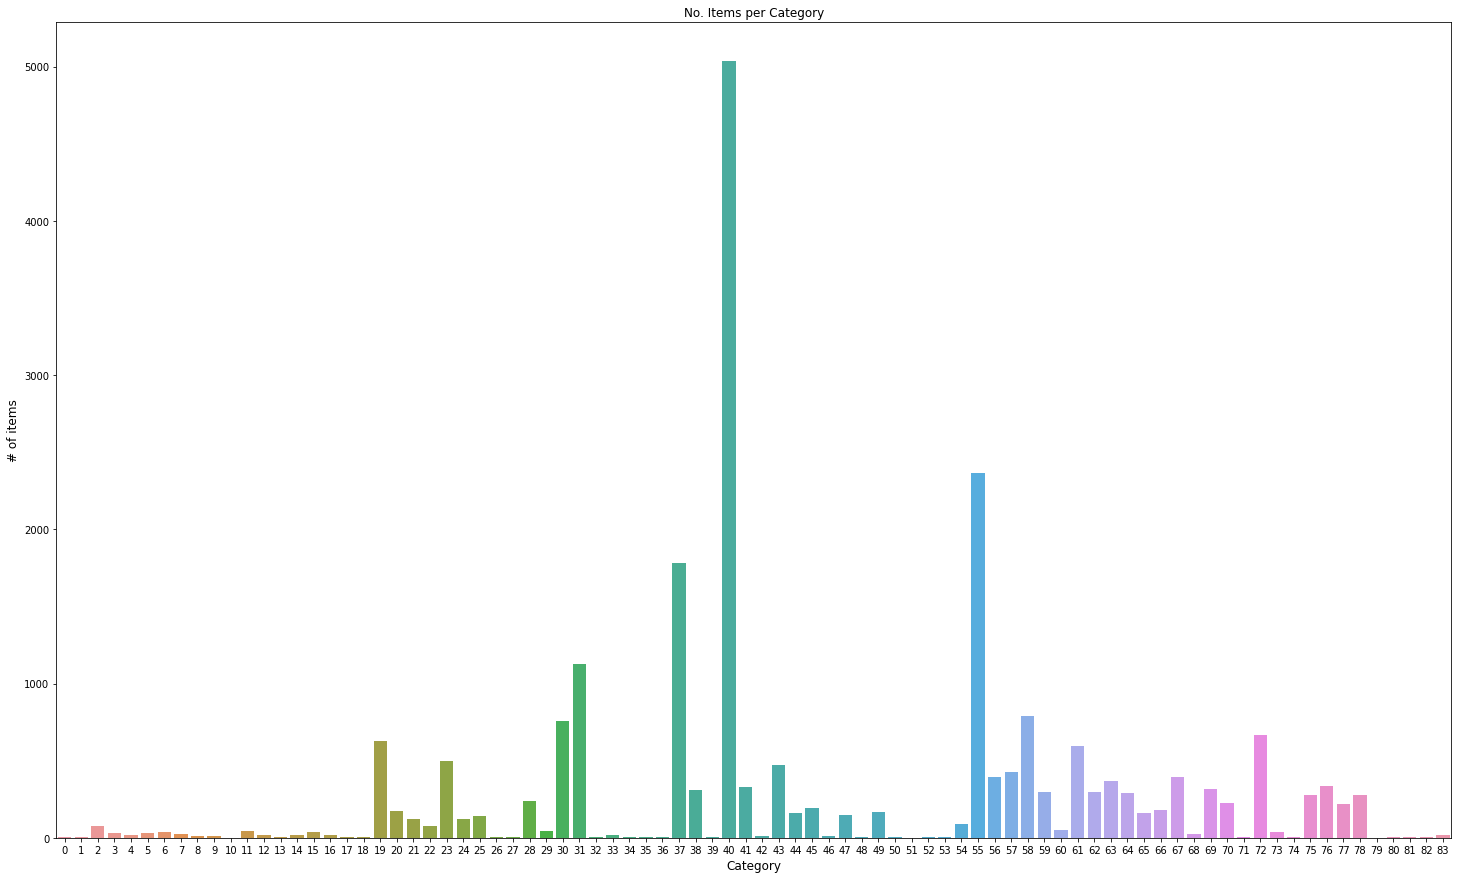

In [11]:
x = items.groupby('item_category_id').agg({'item_id':'count'})
#x=x.sort_values(by='item_id',ascending=False)
x=x.reset_index()
print(x)


plt.figure(figsize=(25,15))
ax = sns.barplot(x.item_category_id, x.item_id)
plt.title("No. Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [12]:
ts = sales.groupby('date_block_num')['item_cnt_day'].sum()
ts_sns = ts.reset_index()


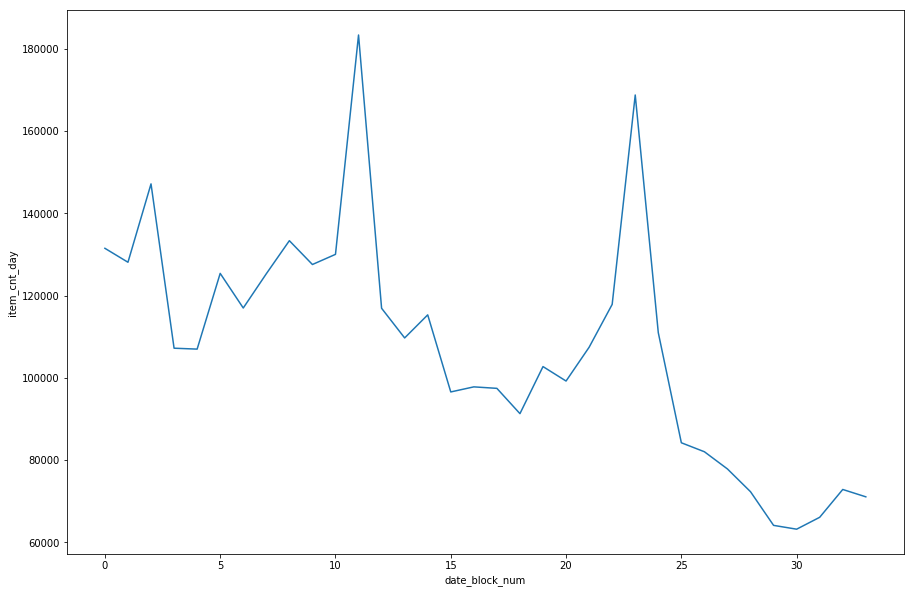

In [13]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(ts_sns.date_block_num,ts_sns.item_cnt_day)
plt.show()

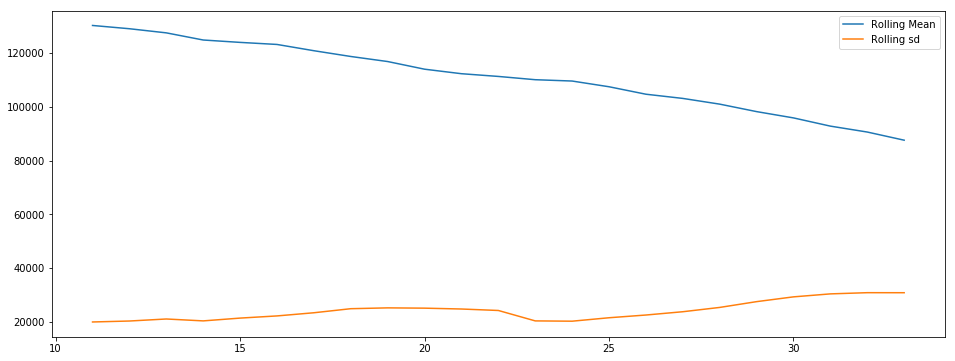

In [14]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

Quick observations: There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.

* https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

* https://medium.com/better-programming/a-visual-guide-to-time-series-decomposition-analysis-a1472bb9c930

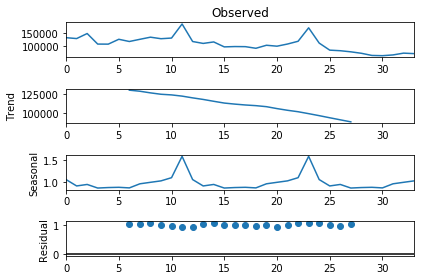

In [15]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()
fig.show()

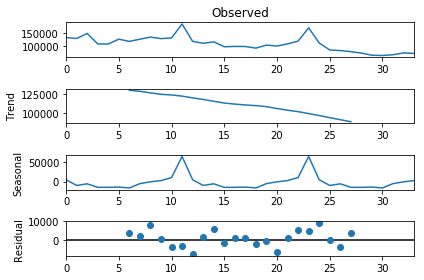

In [16]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

we assume an additive model, then we can write

> yt=St+Tt+Et 

where yt is the data at period t, St is the seasonal component at period t, Tt is the trend-cycle component at period tt and Et is the remainder (or irregular or error) component at period t
Similarly for Multiplicative model,

> yt=St  x Tt x Et 

## Stationarity:

![q](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=750w)

Stationarity refers to time-invariance of a series. (ie) Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.


There are multiple tests that can be used to check stationarity.
* ADF( Augmented Dicky Fuller Test) 
* KPSS 
* PP (Phillips-Perron test)

Let's just perform the ADF which is the most commonly used one.

Note: [Step by step guide to perform dicky fuller test in Excel](http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/)

[Another Useful guide](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#AR) 

[good reference](https://github.com/ultimatist/ODSC17/blob/master/Time%20Series%20with%20Python%20(ODSC)%20STA.ipynb)


In [17]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
test_stationarity(ts)



Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [18]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)): #12 to 32
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob


[]

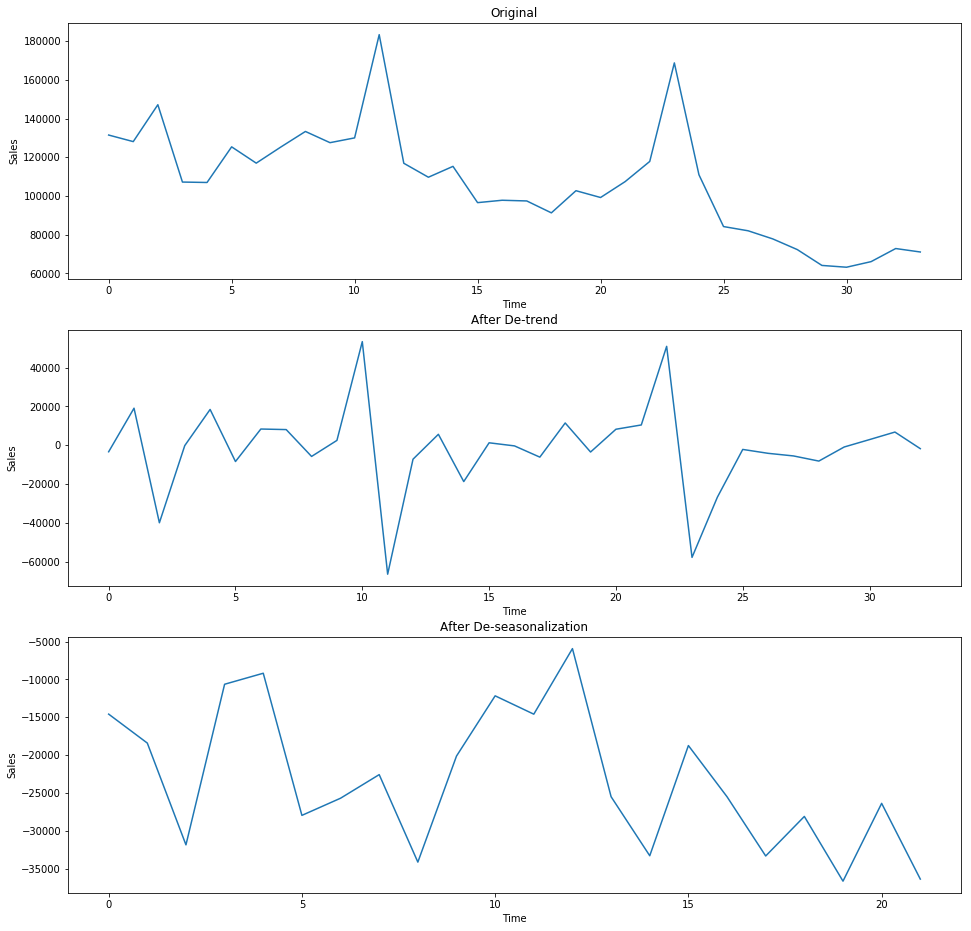

In [19]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts_a=difference(ts)
plt.plot(new_ts_a)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [20]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [21]:
test_stationarity(new_ts_a)

Results of Dickey-Fuller Test:
Test Statistic                -1.363622e+01
p-value                        1.686395e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


### Now after the transformations, our p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series


Find out, if our time-series is in AR process or MA process?